# Model Desrciption
The program downloads and preprocesses the Sign Language MNIST dataset, then builds, trains, and evaluates multiple neural network classifiers for recognizing hand-sign images. It trains both a dense baseline model and several convolutional neural networks with different optimizers, using early stopping to prevent overfitting. Training time and best validation accuracy are automatically logged, model performance is evaluated on a test set, results are summarized in a comparison table, and the trained models are saved for later use.

In [1]:
import kagglehub
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import time
from functools import wraps
import os
import json

# -----------------------
# Decorator to log training
def log_training(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        self = args[0]  # First arg is always the instance
        print(f"\nStarting training for {self.model_name}...")
        start_time = time.time()

        history = func(*args, **kwargs)

        end_time = time.time()
        duration = end_time - start_time
        best_val_acc = self.best_val_acc
        print(f"Finished training {self.model_name} in {duration:.2f}s")
        print(f"Best validation accuracy for {self.model_name}: {best_val_acc:.4f}\n")
        return history
    return wrapper

# -----------------------
# ASL Model Class
class ASLModel:
    def __init__(self, model_name="Model", input_shape=(28,28,1), num_classes=26):
        self.model = None
        self.model_name = model_name
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.history = None
        self.early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

    # -----------------------
    def build_dense(self):
        self.model = Sequential([
            Flatten(input_shape=self.input_shape),
            Dense(128, activation="relu"),
            Dense(64, activation="relu"),
            Dense(self.num_classes, activation="softmax")
        ])
        self.model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

    # -----------------------
    def build_cnn(self, conv_layers=None, dense_layers=None, optimizer="adam",
                  use_dropout=False, use_batchnorm=False, l2_reg=0.0):
        """
        Flexible CNN builder.
        conv_layers: list of tuples (filters, kernel_size, pool_size)
        dense_layers: list of integers (units)
        """
        self.model = Sequential()
        
        if conv_layers is None:
            conv_layers = [(16, (3,3), (2,2)), (32, (3,3), (2,2))]
        if dense_layers is None:
            dense_layers = [64]

        # Add convolutional layers
        for i, (filters, kernel_size, pool_size) in enumerate(conv_layers):
            if i == 0:
                self.model.add(Conv2D(filters, kernel_size, activation="relu",
                                      input_shape=self.input_shape,
                                      kernel_regularizer=l2(l2_reg) if l2_reg>0 else None))
            else:
                self.model.add(Conv2D(filters, kernel_size, activation="relu",
                                      kernel_regularizer=l2(l2_reg) if l2_reg>0 else None))
            if use_batchnorm:
                self.model.add(BatchNormalization())
            self.model.add(MaxPooling2D(pool_size))

        self.model.add(Flatten())

        # Add dense layers
        for units in dense_layers:
            self.model.add(Dense(units, activation="relu",
                                 kernel_regularizer=l2(l2_reg) if l2_reg>0 else None))
            if use_dropout:
                self.model.add(Dropout(0.6))

        # Output layer
        self.model.add(Dense(self.num_classes, activation="softmax"))

        # Optimizer selection
        if optimizer=="adam":
            opt = Adam()
        elif optimizer=="sgd":
            opt = SGD()
        elif optimizer=="rmsprop":
            opt = RMSprop()
        else:
            raise ValueError("Unsupported optimizer")

        self.model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

    # -----------------------
    @log_training
    def train(self, X_train, y_train, X_val, y_val, epochs=5, batch_size=64):
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=[self.early_stop]
        )
        return self.history

    # -----------------------
    def evaluate(self, X_test, y_test):
        loss, acc = self.model.evaluate(X_test, y_test, verbose=0)
        return loss, acc

    # Lambda property for best val accuracy
    best_val_acc = property(lambda self: max(self.history.history["val_accuracy"])
                            if self.history and self.history.history["val_accuracy"] else None)

    # -----------------------
    def save(self, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        self.model.save(path)

# -----------------------
# Data Loading and Preprocessing
path = kagglehub.dataset_download("datamunge/sign-language-mnist")
train_data = pd.read_csv(f"{path}/sign_mnist_train.csv")
test_data = pd.read_csv(f"{path}/sign_mnist_test.csv")

y_train = train_data["label"].values
y_test = test_data["label"].values
X_train = train_data.drop("label", axis=1).values
X_test = test_data.drop("label", axis=1).values

X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

y_train = to_categorical(y_train, num_classes=26)
y_test = to_categorical(y_test, num_classes=26)

# -----------------------
# Train Dense Model
dense_model = ASLModel("Dense Model")
dense_model.build_dense()
dense_model.train(X_train, y_train, X_test, y_test, epochs=5, batch_size=64)
loss, acc = dense_model.evaluate(X_test, y_test)
print(f"Dense model final evaluation - loss: {loss:.4f}, accuracy: {acc:.4f}")

# Save Dense model history
with open("src/ASL-classifier-model/dense_history.json", "w") as f:
    json.dump(dense_model.history.history, f)

# -----------------------
# Train CNN Models with flexible architecture
optimizers = ["adam", "sgd", "rmsprop"]
cnn_models = {}
for opt in optimizers:
    cnn = ASLModel(f"CNN ({opt})")
    cnn.build_cnn(
        conv_layers=[(16,(3,3),(2,2)), (32,(3,3),(2,2))],  # Can customize later
        dense_layers=[64],
        optimizer=opt,
        use_dropout=True,
        use_batchnorm=True,
        l2_reg=0.005
    )
    cnn.train(X_train, y_train, X_test, y_test, epochs=5, batch_size=64)
    cnn_models[opt] = cnn

# Save CNN histories
for opt, cnn in cnn_models.items():
    with open(f"src/ASL-classifier-model/cnn_{opt}_history.json", "w") as f:
        json.dump(cnn.history.history, f)

# -----------------------
# Automatic model comparison table
import pandas as pd

comparison = []
# Dense model
comparison.append({
    "Model": dense_model.model_name,
    "Best Val Accuracy": dense_model.best_val_acc,
    "Test Accuracy": dense_model.evaluate(X_test, y_test)[1]
})

# CNN models
for cnn in cnn_models.values():
    comparison.append({
        "Model": cnn.model_name,
        "Best Val Accuracy": cnn.best_val_acc,
        "Test Accuracy": cnn.evaluate(X_test, y_test)[1]
    })

df_comparison = pd.DataFrame(comparison).sort_values(by="Best Val Accuracy", ascending=False)
print("\nModel Comparison Table:")
print(df_comparison)

# -----------------------
# Save models
dense_model.save("src/ASL-classifier-model/asl_dense_model.h5")
cnn_models["adam"].save("src/ASL-classifier-model/asl_cnn_model.h5")

C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Starting training for Dense Model...
Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3197 - loss: 2.2629 - val_accuracy: 0.5036 - val_loss: 1.6725
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5775 - loss: 1.3336 - val_accuracy: 0.5618 - val_loss: 1.3863
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6859 - loss: 1.0001 - val_accuracy: 0.6244 - val_loss: 1.2413
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7638 - loss: 0.7661 - val_accuracy: 0.6627 - val_loss: 1.1342
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8267 - loss: 0.5877 - val_accuracy: 0.6559 - val_loss: 1.0553
Finished training Dense Model in 19.37s
Best validation accuracy for Dense Model: 0.6627

Dense model final evaluation - loss: 1.0553, accuracy: 0.6559


C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Starting training for CNN (adam)...
Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.5727 - loss: 1.9719 - val_accuracy: 0.6506 - val_loss: 1.7775
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.8888 - loss: 0.7464 - val_accuracy: 0.9142 - val_loss: 0.6382
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.9399 - loss: 0.4819 - val_accuracy: 0.7973 - val_loss: 0.9139
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9601 - loss: 0.3574 - val_accuracy: 0.9112 - val_loss: 0.4890
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9627 - loss: 0.3142 - val_accuracy: 0.9262 - val_loss: 0.4128
Finished training CNN (adam) in 84.30s
Best validation accuracy for CNN (adam): 0.9262


Starting training for CNN (sgd)...
Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.3410 - loss: 2.9110 - val_accuracy: 0.5685 - val_loss: 2.5891
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 


Model Comparison Table:
           Model  Best Val Accuracy  Test Accuracy
3  CNN (rmsprop)           0.941299       0.941299
1     CNN (adam)           0.926241       0.926241
2      CNN (sgd)           0.857780       0.857780
0    Dense Model           0.662716       0.655884


# Summary of Changes

The original procedural script was refactored into a modular, object-oriented pipeline that cleanly separates data handling, model construction, training, and evaluation. Training is now monitored with a decorator and early stopping to reduce overfitting, CNN architectures are fully configurable, and both dense and CNN models are evaluated consistently. The final version also automatically compares models and reports performance, making experimentation clearer, safer, and easier to extend.


In [2]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

# -----------------------
# Load saved models
dense_model = load_model("src/ASL-classifier-model/asl_dense_model.h5")
cnn_model = load_model("src/ASL-classifier-model/asl_cnn_model.h5")

models = {
    "Dense Model": dense_model,
    "CNN Model (Adam)": cnn_model
}

# -----------------------
# Inspect each model
for name, model in models.items():
    print("=" * 60)
    print(f"{name}")
    print("=" * 60)

    # Architecture
    print("\nModel summary:")
    model.summary()

    # Parameter counts
    total_params = model.count_params()
    trainable_params = np.sum([np.prod(w.shape) for w in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(w.shape) for w in model.non_trainable_weights])

    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")

    # Optimizer details
    optimizer = model.optimizer
    print("\nOptimizer configuration:")
    print(optimizer.get_config())

    # Evaluation on test data
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest loss: {loss:.4f}")
    print(f"Test accuracy: {acc:.4f}")

print("\nModel inspection complete.")


Dense Model

Model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,428 (431.36 KB)

 Trainable params: 110,426 (431.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


Total parameters: 110,426
Trainable parameters: 110,426
Non-trainable parameters: 0.0

Optimizer configuration:
{'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}

Test loss: 1.0553
Test accuracy: 0.6559
CNN Model (Adam)

Model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,948 (226.36 KB)

 Trainable params: 57,850 (225.98 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 2 (12.00 B)


Total parameters: 57,946
Trainable parameters: 57,850
Non-trainable parameters: 96

Optimizer configuration:
{'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}

Test loss: 0.4128
Test accuracy: 0.9262

Model inspection complete.


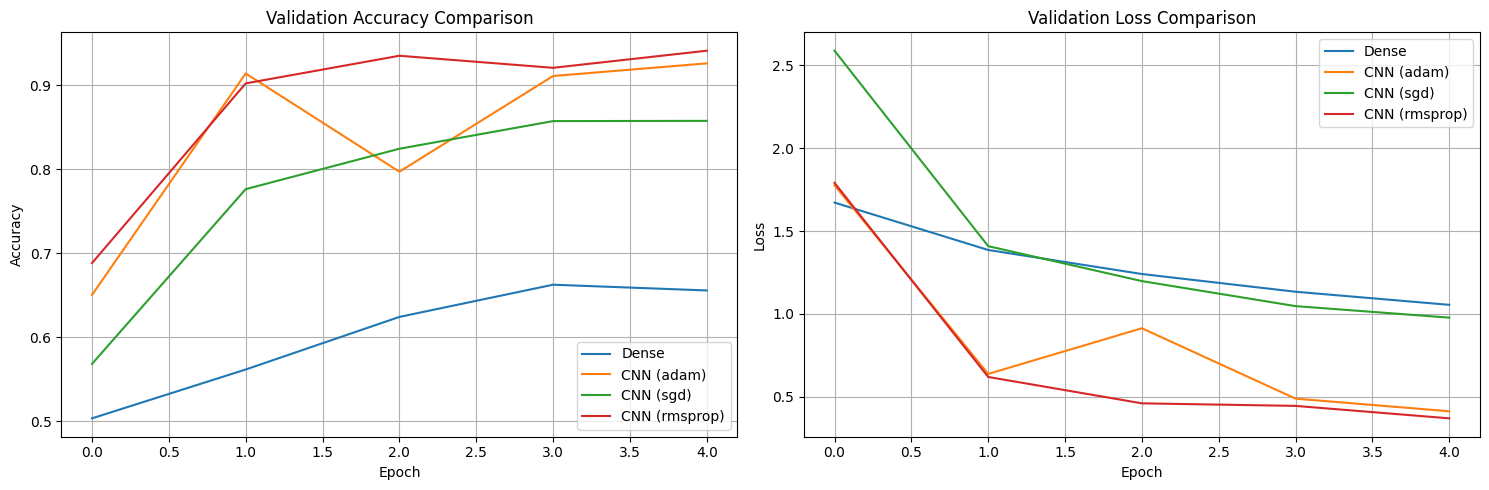

In [4]:
import os
import matplotlib.pyplot as plt

# -----------------------
# Load histories from JSON
history_files = {
    "Dense": "src/ASL-classifier-model/dense_history.json",
    "CNN (adam)": "src/ASL-classifier-model/cnn_adam_history.json",
    "CNN (sgd)": "src/ASL-classifier-model/cnn_sgd_history.json",
    "CNN (rmsprop)": "src/ASL-classifier-model/cnn_rmsprop_history.json",
}

histories = {}
for name, path in history_files.items():
    if os.path.exists(path):
        with open(path, "r") as f:
            histories[name] = json.load(f)
    else:
        print(f"Warning: history file {path} not found.")

# -----------------------
# Plot Validation Accuracy and Loss
plt.figure(figsize=(15, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
for name, h in histories.items():
    if "val_accuracy" in h:
        plt.plot(h["val_accuracy"], label=name)
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss comparison
plt.subplot(1, 2, 2)
for name, h in histories.items():
    if "val_loss" in h:
        plt.plot(h["val_loss"], label=name)
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


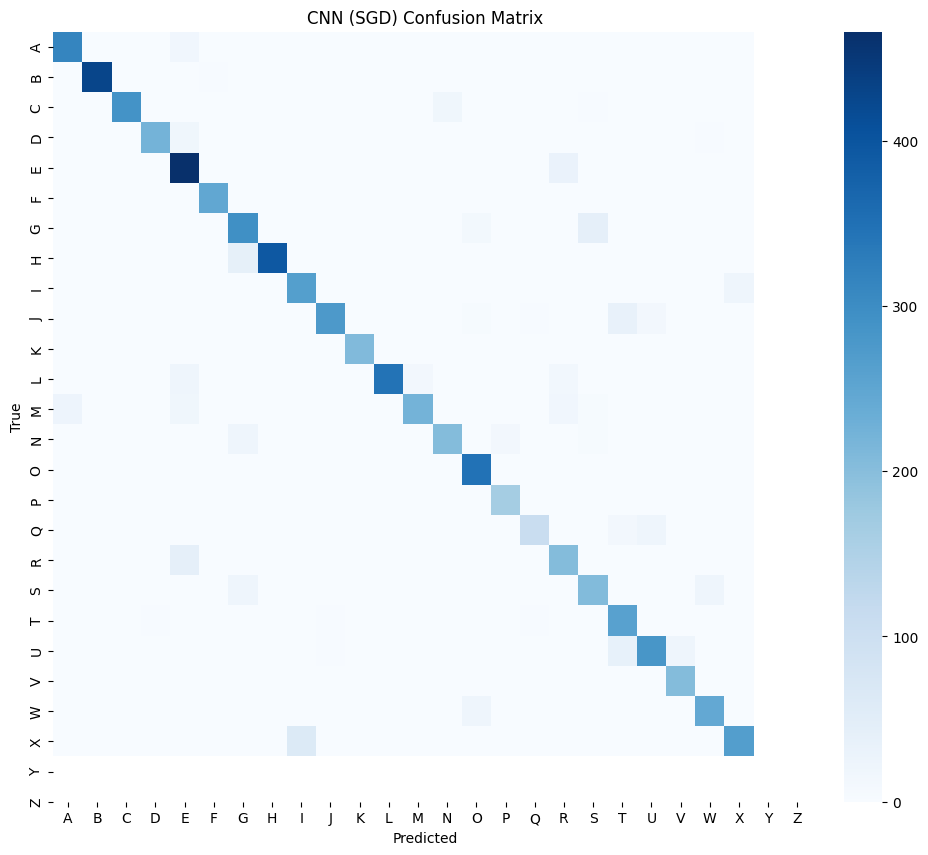

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, X, y_true, classes, title="Confusion Matrix"):
    y_pred = model.predict(X, verbose=0)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)

    cm = confusion_matrix(y_true_labels, y_pred_labels)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=False,        # set True if you want numbers (gets busy)
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Class labels A–Z
classes = [chr(i + 65) for i in range(26)]

# Confusion matrix for best CNN (Adam)
plot_confusion_matrix(
    cnn_models["sgd"].model,
    X_test,
    y_test,
    classes,
    title="CNN (SGD) Confusion Matrix"
)
